In [ ]:
from dk_model import DeepKrigingTrainer
import pandas as pd 
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import gstools as gs
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gstools import Exponential, Stable, vario_estimate_unstructured, Cubic, Gaussian
import matplotlib.pyplot as plt


c:\Users\23478671\Anaconda3\envs\geostatistics\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
deposit_data = pd.read_csv("Data/final_dataset_1_no_0.csv", low_memory=False)

In [3]:
dens_data = pd.read_csv("Data/filtered_unnormalised_deposit_data.csv", low_memory=False)

<Figure size 800x600 with 0 Axes>

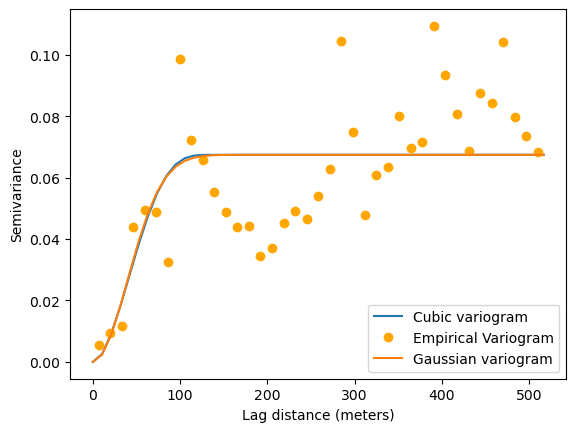

Cubic Model Parameters:
Cubic(dim=3, var=0.0674, len_scale=1.36e+02, nugget=0.0)

Gaussian Model Parameters:
Gaussian(dim=3, var=0.0674, len_scale=49.8, nugget=0.0)


In [ ]:
x = dens_data['X'].values
y = dens_data['Y'].values
z = dens_data['Z'].values
density = dens_data['Density_gcm3'].values

max_dist = np.max([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]) / 4.3
bins = np.linspace(0, max_dist, 40)

bin_center, gamma = vario_estimate_unstructured((x, y, z), density, bins)

cubic_model = Cubic(dim=3)
cubic_model.fit_variogram(bin_center, gamma, nugget=False)

gaussian_model = Gaussian(dim=3)
gaussian_model.fit_variogram(bin_center, gamma, nugget=False)

plt.figure(figsize=(8, 6))

ax = cubic_model.plot(x_max=bins.max(), label="Cubic variogram")
# Add the empirical variogram
ax.plot(bin_center, gamma, 'o', label='Empirical Variogram', color='orange')

gaussian_model.plot(ax=ax, x_max=bins.max(), label="Gaussian variogram")

ax.set_xlabel('Lag distance (meters)')
ax.set_ylabel('Semivariance')
plt.legend()

plt.show()

print("Cubic Model Parameters:")
print(cubic_model)
print("\nGaussian Model Parameters:")
print(gaussian_model)


In [7]:
total_columns = ['CP_Total','PO_Total', 'PY_Total']

#all covariates
covariates = total_columns[:3] + ['RQD_Pct', 'Cr_ppm'] 

In [8]:
phi_columns = deposit_data.columns[10:].tolist()


# 1. Deepkriging and DNN

In [9]:
print("Metrics for Deepkriging")
trainer = DeepKrigingTrainer(deposit_data, regular_nn=False, plot_errors=True)
trainer.train_neural_network()

print("\nMetrics for regular DNN")
trainer = DeepKrigingTrainer(deposit_data, regular_nn=True, plot_errors=True)
trainer.train_neural_network()

print("\nMetrics for Deepkriging with covariates")
trainer = DeepKrigingTrainer(deposit_data, covariates, regular_nn=False, plot_errors=False)
trainer.train_neural_network()

print("\nMetrics for regular DNN with covariates")
trainer = DeepKrigingTrainer(deposit_data, covariates, regular_nn=True, plot_errors=False)
trainer.train_neural_network()


Metrics for Deepkriging

Average Metrics Across Folds:
  Average MSE: 0.0022
  Average MAE: 0.0332
  Average Adjusted R2: 1.1679
  Average R2: 0.8537

Metrics for regular DNN

Average Metrics Across Folds:
  Average MSE: 0.0043
  Average MAE: 0.0452
  Average Adjusted R2: 0.7078
  Average R2: 0.7112

Metrics for Deepkriging with covariates

Average Metrics Across Folds:
  Average MSE: 0.0018
  Average MAE: 0.0285
  Average Adjusted R2: 1.1308
  Average R2: 0.8835

Metrics for regular DNN with covariates

Average Metrics Across Folds:
  Average MSE: 0.0040
  Average MAE: 0.0366
  Average Adjusted R2: 0.7145
  Average R2: 0.7233


# 2. Reg kriging 

In [10]:
np.random.seed(42)

y = deposit_data['Density_gcm3'].values  
x = deposit_data[['X', 'Y', 'Z', 'CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']].values

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

mse_list, mae_list, adjusted_r2_list, r2_list = [], [], [], []

for train_index, test_index in kf.split(x):
    X_cv_train, X_cv_test = x[train_index], x[test_index]
    y_cv_train, y_cv_test = y[train_index], y[test_index]

    regression_model = LinearRegression()
    regression_model.fit(X_cv_train, y_cv_train)

    y_cv_pred = regression_model.predict(X_cv_test)

    residuals_train = y_cv_train - regression_model.predict(X_cv_train).flatten()
#Linear
    model = gs.Cubic(dim=3)
    krige = gs.krige.Ordinary(model, cond_pos=[X_cv_train[:, 0], X_cv_train[:, 1], X_cv_train[:, 2]], cond_val=residuals_train, fit_variogram=True)

    kriging_pred, kriging_var = krige([X_cv_test[:, 0], X_cv_test[:, 1], X_cv_test[:, 2]], return_var=True)

    final_cv_predictions = y_cv_pred.flatten() + kriging_pred

    mse = mean_squared_error(y_cv_test, final_cv_predictions)
    mae = mean_absolute_error(y_cv_test, final_cv_predictions)
    
    sst = np.sum((y_cv_test - np.mean(y_cv_test)) ** 2)
    ssr = np.sum((y_cv_test - final_cv_predictions) ** 2)
    r2 = 1 - (ssr / sst)
    
    n = len(y_cv_test)
    num_predictors = X_cv_test.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

    mse_list.append(mse)
    mae_list.append(mae)
    adjusted_r2_list.append(adjusted_r2)
    r2_list.append(r2)

print("Metrics for regression kriging with covariates")
print("\nAverage Metrics Across Folds:")
print(f"  Average MSE: {np.mean(mse_list):.4f}")
print(f"  Average MAE: {np.mean(mae_list):.4f}")
print(f"  Average adjusted R2: {np.mean(adjusted_r2_list):.4f}")
print(f"  Average R2: {np.mean(r2_list):.4f}")


Metrics for regression kriging with covariates

Average Metrics Across Folds:
  Average MSE: 0.0023
  Average MAE: 0.0261
  Average adjusted R2: 0.8390
  Average R2: 0.8439


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

np.random.seed(42)

covariance_models = {
    "Gaussian": gs.Gaussian(dim=3),
    "Matern": gs.Matern(dim=3),
    "Integral": gs.Integral(dim=3),
    "Rational": gs.Rational(dim=3),
    "Cubic": gs.Cubic(dim=3),
}

y = deposit_data['Density_gcm3'].values  
x = deposit_data[['X', 'Y', 'Z', 'CP_Total', 'PO_Total', 'PY_Total', 'RQD_Pct', 'Cr_ppm']].values

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

results = {}

# Loop over each covariance model
for model_name, model in covariance_models.items():
    mse_list, mae_list, adjusted_r2_list = [], [], []

    for train_index, test_index in kf.split(x):
        X_cv_train, X_cv_test = x[train_index], x[test_index]
        y_cv_train, y_cv_test = y[train_index], y[test_index]

        regression_model = LinearRegression()
        regression_model.fit(X_cv_train, y_cv_train)

        y_cv_pred = regression_model.predict(X_cv_test)
        residuals_train = y_cv_train - regression_model.predict(X_cv_train).flatten()

        krige = gs.krige.Ordinary(model, cond_pos=[X_cv_train[:, 0], X_cv_train[:, 1], X_cv_train[:, 2]], 
                                  cond_val=residuals_train, fit_variogram=True)

        kriging_pred, kriging_var = krige([X_cv_test[:, 0], X_cv_test[:, 1], X_cv_test[:, 2]], return_var=True)

        final_cv_predictions = y_cv_pred.flatten() + kriging_pred

        mse = mean_squared_error(y_cv_test, final_cv_predictions)
        mae = mean_absolute_error(y_cv_test, final_cv_predictions)
        
        sst = np.sum((y_cv_test - np.mean(y_cv_test)) ** 2)
        ssr = np.sum((y_cv_test - final_cv_predictions) ** 2)
        r2 = 1 - (ssr / sst)

        n = len(y_cv_test)
        num_predictors = X_cv_test.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))

        mse_list.append(mse)
        mae_list.append(mae)
        adjusted_r2_list.append(adjusted_r2)

    # Store the mean metrics for the current model
    results[model_name] = {
        "mean_mse": np.mean(mse_list),
        "mean_mae": np.mean(mae_list),
        "mean_adjusted_r2": np.mean(adjusted_r2_list)
    }

    # Print results for the current model
    print(f"Metrics for regression kriging with {model_name} covariance model:")
    print(f"  Average MSE: {np.mean(mse_list):.4f}")
    print(f"  Average MAE: {np.mean(mae_list):.4f}")
    print(f"  Average adjusted R2: {np.mean(adjusted_r2_list):.4f}")
    print()



Metrics for regression kriging with Gaussian covariance model:
  Average MSE: 8.5895
  Average MAE: 0.2257
  Average adjusted R2: -638.1673

Metrics for regression kriging with Matern covariance model:
  Average MSE: 6.8046
  Average MAE: 0.1521
  Average adjusted R2: -424.0023

Metrics for regression kriging with Integral covariance model:
  Average MSE: 10.1527
  Average MAE: 0.2449
  Average adjusted R2: -787.1874

Metrics for regression kriging with Rational covariance model:
  Average MSE: 7.8921
  Average MAE: 0.2345
  Average adjusted R2: -603.3987

Metrics for regression kriging with Cubic covariance model:
  Average MSE: 0.0023
  Average MAE: 0.0261
  Average adjusted R2: 0.8390



# Kriging 

In [11]:
np.random.seed(42)


y = deposit_data['Density_gcm3'].values.flatten()  
x = deposit_data[['X', 'Y', 'Z']].values

mse_list = []
mae_list = []
test_adjusted_r2_list = []
r2_list = []

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

for train_index, test_index in kf.split(x):
    X_cv_train, X_cv_test = x[train_index], x[test_index]
    y_cv_train, y_cv_test = y[train_index], y[test_index]

    model = gs.Gaussian(dim=3)
    krige = gs.krige.Ordinary(model, cond_pos=[X_cv_train[:, 0], X_cv_train[:, 1], X_cv_train[:, 2]], cond_val=y_cv_train, fit_variogram=True)

    kriging_pred, kriging_var = krige([X_cv_test[:, 0], X_cv_test[:, 1], X_cv_test[:, 2]], return_var=True)

    final_cv_predictions = kriging_pred

    mse = mean_squared_error(y_cv_test, final_cv_predictions)
    mae = mean_absolute_error(y_cv_test, final_cv_predictions)
    mse_list.append(mse)
    mae_list.append(mae)

    n = len(y_cv_test)
    sst = np.sum((y_cv_test - np.mean(y_cv_test)) ** 2)
    ssr = np.sum((y_cv_test - final_cv_predictions) ** 2)
    r2 = 1 - (ssr / sst)

    num_predictors = X_cv_test.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
    test_adjusted_r2_list.append(adjusted_r2)
    r2_list.append(r2)
# Calculate mean metrics across folds
mean_mse = np.mean(mse_list)
mean_mae = np.mean(mae_list)
mean_a_r2 = np.mean(test_adjusted_r2_list)
mean_r2 = np.mean(r2_list)

print("Metrics for 3D kriging")
print(f"  Average MSE: {mean_mse:.5f}")
print(f"  Average MAE: {mean_mae:.5f}")
print(f"  Average adjusted R2: {mean_a_r2:.5f}")
print(f"  Average R2: {mean_r2:.5f}")


Metrics for 3D kriging
  Average MSE: 0.00284
  Average MAE: 0.03841
  Average adjusted R2: 0.81229
  Average R2: 0.81445


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold

# Seed for reproducibility
np.random.seed(42)

# Define covariance models
covariance_models = {
    "Gaussian": gs.Gaussian(dim=3),
    "Rational": gs.Rational(dim=3),
    "Cubic": gs.Cubic(dim=3),
}

y = deposit_data['Density_gcm3'].values.flatten()  
x = deposit_data[['X', 'Y', 'Z']].values

num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

results = {}

for model_name, model in covariance_models.items():
    mse_list = []
    mae_list = []
    test_adjusted_r2_list = []

    for train_index, test_index in kf.split(x):
        X_cv_train, X_cv_test = x[train_index], x[test_index]
        y_cv_train, y_cv_test = y[train_index], y[test_index]

        krige = gs.krige.Ordinary(model, cond_pos=[X_cv_train[:, 0], X_cv_train[:, 1], X_cv_train[:, 2]], 
                                  cond_val=y_cv_train, fit_variogram=True)

        kriging_pred, kriging_var = krige([X_cv_test[:, 0], X_cv_test[:, 1], X_cv_test[:, 2]], return_var=True)

        final_cv_predictions = kriging_pred

        mse = mean_squared_error(y_cv_test, final_cv_predictions)
        mae = mean_absolute_error(y_cv_test, final_cv_predictions)
        mse_list.append(mse)
        mae_list.append(mae)

        n = len(y_cv_test)
        sst = np.sum((y_cv_test - np.mean(y_cv_test)) ** 2)
        ssr = np.sum((y_cv_test - final_cv_predictions) ** 2)
        r2 = 1 - (ssr / sst)

        num_predictors = X_cv_test.shape[1]
        adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - num_predictors - 1))
        test_adjusted_r2_list.append(adjusted_r2)

    mean_mse = np.mean(mse_list)
    mean_mae = np.mean(mae_list)
    mean_a_r2 = np.mean(test_adjusted_r2_list)

    results[model_name] = {
        "mean_mse": mean_mse,
        "mean_mae": mean_mae,
        "mean_adjusted_r2": mean_a_r2
    }

    # Print results for the current model
    print(f"Metrics for {model_name} covariance model:")
    print(f"  Average MSE: {mean_mse:.5f}")
    print(f"  Average MAE: {mean_mae:.5f}")
    print(f"  Average adjusted R2: {mean_a_r2:.5f}")



Metrics for Gaussian covariance model:
  Average MSE: 0.00284
  Average MAE: 0.03841
  Average adjusted R2: 0.81229
Metrics for Rational covariance model:
  Average MSE: 0.00280
  Average MAE: 0.03815
  Average adjusted R2: 0.81520
Metrics for Cubic covariance model:
  Average MSE: 0.00279
  Average MAE: 0.03786
  Average adjusted R2: 0.81589
